In [1]:
import numpy as np
## Tom's utilities file
import sys
utils_path = '/Users/work/Utilities'  # Change as needed
if not utils_path in sys.path :
    sys.path.insert(0, utils_path)
import utilities
import corner
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
rc('text', usetex=True)
font_options = {'family':'serif', 'serif':'cm', 'size':18}
rc('font', **font_options)

a) We can use three equations to find $u_x$ and $u_y$ in terms of $R$, $g$, and $h$:

$$0 = u_y^2 - 2 g h \Rightarrow u_y = \sqrt{2 g h}$$
$$0 = u_y - \frac{g t}{2} = \sqrt{2 g h} - \frac{g t}{2} \Rightarrow t = \sqrt{\frac{8 h}{g}}$$
$$R = u_x t = u_x \sqrt{\frac{8 h}{g}} \Rightarrow u_x = R \sqrt{\frac{g}{8 h}}$$

The expected values for $u_x$ and $u_y$ for this approach are just the values we get when we use $R_0$, $h_0$, and $g_0$:

$$u_x^0 = R_0 \sqrt{\frac{g_0}{8 h_0}} = 10.0 \mathrm{m} \sqrt{\frac{9.81 \mathrm{m}\cdot\mathrm{s}^{-2}}{8 \cdot 1.0 \mathrm{m}}} \approx 11.1 \mathrm{m}\cdot\mathrm{s}^{-1}$$

$$u_y^0 = \sqrt{2 g_0 h_0} = \sqrt{2 \cdot 9.81 \mathrm{m}\cdot\mathrm{s}^{-2} \cdot 1.0 \mathrm{m}} \approx 4.43 \mathrm{m}\cdot\mathrm{s}^{-1}$$

We can use the logarithim and standard propagation of errors to infer the fractional uncertainties in $u_x$ and $u_y$ given $\sigma_R$, $\sigma_h$, and $\sigma_g$:

$$\ln u_x = \ln\left(R \sqrt{\frac{g}{8 h}}\right) = \ln R + \frac{1}{2} \ln g - \frac{1}{2} \ln 8 - \frac{1}{2} \ln h$$

$$\Rightarrow \frac{\sigma_{u_x}}{u_x} = \sqrt{\left(\frac{\sigma_R}{R_0}\right)^2 + \frac{1}{4} \left(\frac{\sigma_g}{g_0}\right)^2 + \frac{1}{4} \left(\frac{\sigma_h}{h_0}\right)^2} = \sqrt{\left(\frac{0.2}{10.0}\right)^2 + \frac{1}{4} \left(\frac{0.05}{9.81}\right)^2 + \frac{1}{4} \left(\frac{0.2}{1.0}\right)^2} \approx 0.10$$

$$\ln u_y = \ln \sqrt{2 g h} = \frac{1}{2} \ln 2 + \frac{1}{2} \ln g + \frac{1}{2} \ln h$$

$$\Rightarrow \frac{\sigma_{u_y}}{u_y} = \sqrt{\frac{1}{4} \left(\frac{\sigma_g}{g_0}\right)^2 + \frac{1}{4} \left(\frac{\sigma_h}{h_0}\right)^2} = \frac{1}{2} \sqrt{\left(\frac{0.05}{9.81}\right)^2 + \left(\frac{0.2}{1.0}\right)^2} \approx 0.10$$

b) We now want to use Monte Carlo realizations of $R$, $g$, and $h$ to generate one-dimensional, marginalized distributions for $u_x$ and $u_y$ to compare with the results above. We can plot contours of $u_y$ vs. $u_x$ and the marginalized histograms and compare with the error propagation method results of $u_x = 11.1 \pm 0.10 \mathrm{m}\cdot\mathrm{s}^{-1}$ and $u_y = 4.43 \pm 0.10 \mathrm{m}\cdot\mathrm{s}^{-1}$.

In [2]:
# Set the random seed
np.random.seed(0)
# Choose the number of realizations
Nreal = 1e6
# Set the means and standard deviations for R, g, and h
meanR, sigmaR = 10.0, 0.2
meanh, sigmah = 1.0, 0.2
meang, sigmag = 9.81, 0.05
# Generate Gaussian distributions of R, g, and h with the given means and standard deviations
z1, z2 = utilities.get_fake_gaussian_data(Nreal)
z3 = utilities.get_fake_gaussian_data(Nreal)[0]  # Only need one more!!
Rdist = meanR + sigmaR*z1
hdist = meanh + sigmah*z2
gdist = meang + sigmag*z3

# Now find the ux and uy distributions given the distributions in R, g, and h
frequentist_ux = Rdist*np.sqrt(gdist/(8*hdist))
frequentist_uy = np.sqrt(2*gdist*hdist)

In [3]:
# Also set the mean and uncertainty of ux and uy from the error propagation method
# ep_ux, ep_sigmax = meanR*np.sqrt(meang/(8*meanh)), np.sqrt(np.power(sigmaR/meanR, 2) + np.power(sigmag/(2*meang), 2) + np.power(sigmah/(2*meanh), 2))
ep_ux, ep_sigmax = 11.1, 0.10
# ep_uy, ep_sigmay = np.sqrt(2*meang*meanh), 0.5*np.sqrt(np.power(sigmag/meang, 2) + np.power(sigmah/meanh, 2))
ep_uy, ep_sigmay = 4.43, 0.10

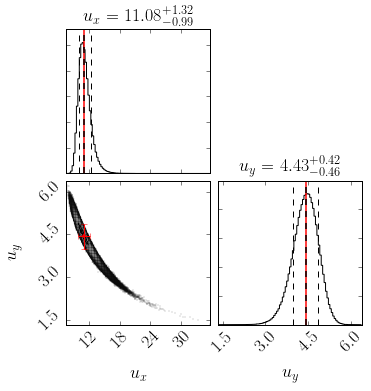

In [4]:
# Make the plots
## I'm going to use the corner.py module, but I want to be able to add the truth values with errorbars myself, so I'll
## set up the figure for it to use following the same method in corner.py
K = 2
factor = 2.0           # size of one side of one panel
lbdim = 0.5 * factor   # size of left/bottom margin
trdim = 0.2 * factor   # size of top/right margin
whspace = 0.05         # w/hspace size
plotdim = factor * K + factor * (K - 1.) * whspace
dim = lbdim + plotdim + trdim
fig, axes = plt.subplots(K, K, figsize=(dim, dim))
data = np.array([frequentist_ux, frequentist_uy]).T
fig = corner.corner(data, bins=100, labels=[r'$u_x$', r'$u_y$'], label_kwargs={'fontsize':font_options['size']}, quantiles=[0.16, 0.84], levels=(1-np.exp(-0.5),), show_titles=True, title_kwargs={'fontsize':font_options['size']}, fig=fig)
ax = axes[1,0]
ax.errorbar(ep_ux, ep_uy, xerr=ep_sigmax*ep_ux, yerr=ep_sigmay*ep_uy, fmt='r.', elinewidth=1)
ax = axes[0,0]
ax.axvline(ep_ux, color='r', linewidth=1.5)
q = corner.quantile(frequentist_ux, (0.5,))
ax.axvline(q, ls='--', color='k', linewidth=1.5)
ax = axes[1,1]
ax.axvline(ep_uy, color='r', linewidth=1.5)
q = corner.quantile(frequentist_uy, (0.5,))
ax.axvline(q, ls='--', color='k', linewidth=1.5)
## Save the figure
pp = PdfPages('hw2_b_corner.pdf')
pp.savefig(fig)
pp.close()